In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "SPY_section_1.csv"
df = pd.read_csv(file_path)

# start to nov 2001 (dot com crash)
# not bad
# df = df.iloc[:2228]

# nov 01 to june 2009
# not bad
# df = df.iloc[2228:4135]

# june 2009 to april 2020
# ass
# df = df.iloc[4135:6862]

# april 2020 to most recent
# ass
# df = df.iloc[6862:]


# Convert the "Date" column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# # Sort the data by date in ascending order
# df = df.sort_values(by="Date")

# # Get the earliest and latest dates
# earliest_date = df["Date"].min()
# latest_date = df["Date"].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)


In [3]:
# Adding SMA as part of the feature test
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [4]:
feature_columns = ["Open", "High", "Low", "Close", "Volume"]
dates = df["Date"]
# if "Open" and "High" and "Low" and "Close" and "Volume" in df.columns:
#     df = df[feature_columns]


In [5]:

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200", "Non_Linear_Trend"]
feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend", "SMA_20", "SMA_50", "EMA_10", "EMA_50"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_200", "EMA_10"]
X = df[feature_columns]

# Split data
train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

# Initialize scaler
scaler = MinMaxScaler()
# scaler = RobustScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

# Split sequentially
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1421, Val: 304, Test: 305


In [6]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [7]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [8]:
# # Check if CUDA is available and print the device being used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# class Encoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, encoding_dim)
#         )

#     def forward(self, x):
#         return self.encoder(x)

# class Decoder(nn.Module):
#     def __init__(self, encoding_dim, input_dim):
#         super(Decoder, self).__init__()
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, input_dim)
#         )

#     def forward(self, x):
#         return self.decoder(x)


# # Define input dimensions
# input_dim = X_train.shape[1]

# # Model file paths
# encoder_model_file = './autoencoder_trials/encoder.pth'
# decoder_model_file = './autoencoder_trials/decoder.pth'

# # Hyperparameters
# encoding_dim = 8
# learning_rate = 0.001
# epochs = 50
# batch_size = 8
# patience = 5

# # Check if the model files exist
# if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
#     print("Model files exist. Loading the models...")
#     encoder = Encoder(input_dim, encoding_dim).to(device)
#     decoder = Decoder(encoding_dim, input_dim).to(device)
#     encoder.load_state_dict(torch.load(encoder_model_file))
#     decoder.load_state_dict(torch.load(decoder_model_file))
# else:
#     print("Model files do not exist. Training new models...")

#     # Initialize the encoder and decoder models
#     encoder = Encoder(input_dim, encoding_dim).to(device)
#     decoder = Decoder(encoding_dim, input_dim).to(device)
#     optimizer_encoder = optim.Adam(encoder.parameters(), lr=learning_rate)
#     optimizer_decoder = optim.Adam(decoder.parameters(), lr=learning_rate)
#     criterion = nn.MSELoss()

#     # Track training loss
#     encoder_losses = []
#     decoder_losses = []

#     # Train the Encoder separately
#     encoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_train, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
#         for i, (batch_X, _) in enumerate(dataloader):
#             batch_X = batch_X.to(device)
#             optimizer_encoder.zero_grad()
#             encoded = encoder(batch_X)
#             # Pass the encoded output through the decoder
#             decoded = decoder(encoded)
#             # Calculate loss between decoder output and original input
#             loss = criterion(decoded, batch_X)
#             loss.backward()

#             optimizer_encoder.step()
#             optimizer_encoder.zero_grad()

#             epoch_loss += loss.item()
#         avg_loss = epoch_loss / len(dataloader)
#         encoder_losses.append(avg_loss)
#         print(f"Epoch [{epoch+1}/{epochs}], Encoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         encoder.eval()
#         decoder.eval()
#         with torch.no_grad():
#             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
#             val_decoded = decoder(val_encoded)
#             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break

#     # Train the Decoder separately
#     encoded_train = encoder(torch.tensor(X_train, dtype=torch.float32).to(device)).detach()
#     decoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(encoded_train, torch.tensor(X_train, dtype=torch.float32).to(device)), batch_size=batch_size, shuffle=True, num_workers=0)
#         for i, (batch_X, batch_y) in enumerate(dataloader):
#             batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#             optimizer_decoder.zero_grad()
#             outputs = decoder(batch_X)
#             # Calculate loss between decoder output and original input
#             loss = criterion(outputs, batch_y)
#             loss.backward()

#             optimizer_decoder.step()
#             optimizer_decoder.zero_grad()

#             epoch_loss += loss.item()
#         avg_loss = epoch_loss / len(dataloader)
#         decoder_losses.append(avg_loss)
#         print(f"Epoch [{epoch+1}/{epochs}], Decoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         decoder.eval()
#         with torch.no_grad():
#             val_outputs = decoder(encoded_train)
#             val_loss = criterion(val_outputs, torch.tensor(X_train, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             print("Early stopping counter:", patience_counter)
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break

#     # Save the trained models
#     os.makedirs('./autoencoder_trials', exist_ok=True)
#     # torch.save(encoder.state_dict(), encoder_model_file)
#     # torch.save(decoder.state_dict(), decoder_model_file)
#     print("Models trained and saved.")

# # Combine Encoder and Decoder to form the Autoencoder
# class Autoencoder(nn.Module):
#     def __init__(self, encoder, decoder):
#         super(Autoencoder, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# autoencoder = Autoencoder(encoder, decoder).to(device)
# autoencoder.eval()

# # Calculate reconstruction error on the test set
# with torch.no_grad():
#     reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# # Calculate Mean Squared Error (MSE)
# mse = np.mean((X_test - reconstructed_test) ** 2)
# print(f'Mean Squared Error (MSE): {mse}')

# # Calculate Mean Absolute Error (MAE)
# mae = np.mean(np.abs(X_test - reconstructed_test))
# print(f'Mean Absolute Error (MAE): {mae}')

# # Calculate Reconstruction Error Percentage
# # reconstruction_error = np.mean(np.square(X_test - reconstructed_test), axis=1)
# # reconstruction_error_percentage = np.mean(reconstruction_error) * 100
# # print(f'Reconstruction Error Percentage: {reconstruction_error_percentage}')

# reconstruction_error_percentage = (
#     np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
# )
# reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
# print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean}')

# def calculate_index_error_percentage(index, X, reconstructed_X):
#     print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)


In [9]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from torch.utils.data import DataLoader, TensorDataset

# # Check if CUDA is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Define Encoder
# class Encoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim, dropout_rate):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, encoding_dim)
#         )

#     def forward(self, x):
#         return self.encoder(x)

# # Define Decoder
# class Decoder(nn.Module):
#     def __init__(self, encoding_dim, input_dim, dropout_rate):
#         super(Decoder, self).__init__()
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(128, input_dim)
#         )

#     def forward(self, x):
#         return self.decoder(x)

# def relative_euclidean_error(X, X_reconstructed):
#     return np.linalg.norm(X - X_reconstructed, axis=1) / np.linalg.norm(X, axis=1)

# class RelativeEuclideanError(nn.Module):
#     def forward(self, y_true, y_pred):
#         return torch.mean(torch.norm(y_true - y_pred, dim=1) / torch.norm(y_true, dim=1))

# # Define input dimensions
# input_dim = X_train.shape[1]

# # Model file paths
# encoder_model_file = './autoencoder_trials/encoder.pth'
# decoder_model_file = './autoencoder_trials/decoder.pth'

# # Hyperparameters
# encoding_dim = 5
# learning_rate = 0.0001
# dropout_rate = 0.0
# epochs = 750
# batch_size = 16
# patience = 30

# # Initialize models
# encoder = Encoder(input_dim, encoding_dim, dropout_rate).to(device)
# decoder = Decoder(encoding_dim, input_dim, dropout_rate).to(device)

# # Define optimizers and loss function
# optimizer_encoder = optim.Adam(encoder.parameters(), lr=learning_rate)
# optimizer_decoder = optim.Adam(decoder.parameters(), lr=learning_rate)
# # criterion = nn.MSELoss()
# criterion = RelativeEuclideanError()
# #use MAE
# # criterion = nn.L1Loss()

# # Add Gaussian noise to encoded representations to avoid overfitting
# def add_noise(encoded, noise_factor=0.01):
#     return encoded + noise_factor * torch.randn_like(encoded)

# # Train Encoder
# def train_encoder():
#     print("Training Encoder...")
#     encoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     # clip_value = 1

#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
#                                               torch.tensor(X_train, dtype=torch.float32).to(device)),
#                                 batch_size=batch_size, shuffle=True, num_workers=0)

#         for batch_X, _ in dataloader:
#             batch_X = batch_X.to(device)
#             optimizer_encoder.zero_grad()
#             encoded = encoder(batch_X)
#             decoded = decoder(encoded)
#             loss = criterion(decoded, batch_X)
#             loss.backward()

#             # torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=clip_value)  # Option 1
#             # torch.nn.utils.clip_grad_value_(encoder.parameters(), clip_value=clip_value)  # Option 2

#             optimizer_encoder.step()
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch [{epoch+1}/{epochs}], Encoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         encoder.eval()
#         decoder.eval()
#         with torch.no_grad():
#             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
#             val_decoded = decoder(val_encoded)
#             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#             torch.save(encoder.state_dict(), encoder_model_file)  # Save best model
#         else:
#             patience_counter += 1
#             print("Early stopping counter:", patience_counter)
#             if patience_counter >= patience:
#                 print("Early stopping triggered for encoder.")
#                 break

# # Train Decoder
# def train_decoder():
#     print("Training Decoder...")
#     encoder.eval()
#     encoded_train = encoder(torch.tensor(X_train, dtype=torch.float32).to(device)).detach()

#     decoder.train()
#     best_val_loss = float('inf')
#     patience_counter = 0
#     # clip_value = 1

#     for epoch in range(epochs):
#         epoch_loss = 0
#         dataloader = DataLoader(TensorDataset(encoded_train, torch.tensor(X_train, dtype=torch.float32).to(device)),
#                                 batch_size=batch_size, shuffle=True, num_workers=0)

#         for batch_X, batch_y in dataloader:
#             batch_X, batch_y = batch_X.to(device), batch_y.to(device)

#             # Add Gaussian noise
#             noisy_batch_X = add_noise(batch_X)

#             optimizer_decoder.zero_grad()
#             outputs = decoder(noisy_batch_X)
#             loss = criterion(outputs, batch_y)
#             loss.backward()

#             # torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=clip_value)  # Option 1
#             # torch.nn.utils.clip_grad_value_(decoder.parameters(), clip_value=clip_value)  # Option 2

#             optimizer_decoder.step()

#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch [{epoch+1}/{epochs}], Decoder Loss: {avg_loss:.4f}")

#         # Validation loss
#         decoder.eval()
#         with torch.no_grad():
#             val_encoded = encoder(torch.tensor(X_val, dtype=torch.float32).to(device))
#             val_decoded = decoder(val_encoded)
#             val_loss = criterion(val_decoded, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
#         print(f"Validation Loss: {val_loss:.4f}")

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#             torch.save(decoder.state_dict(), decoder_model_file)  # Save best model
#         else:
#             patience_counter += 1
#             print("Early stopping counter:", patience_counter)
#             if patience_counter >= patience:
#                 print("Early stopping triggered for decoder.")
#                 break

# # Train models if files do not exist
# if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
#     print("Model files exist. Loading the models...")
#     encoder.load_state_dict(torch.load(encoder_model_file))
#     decoder.load_state_dict(torch.load(decoder_model_file))
# else:
#     os.makedirs('./autoencoder_trials', exist_ok=True)
#     train_encoder()
#     train_decoder()

# # Combine Encoder and Decoder to form the Autoencoder
# class Autoencoder(nn.Module):
#     def __init__(self, encoder, decoder):
#         super(Autoencoder, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# # Load trained models
# encoder.load_state_dict(torch.load(encoder_model_file))
# decoder.load_state_dict(torch.load(decoder_model_file))
# autoencoder = Autoencoder(encoder, decoder).to(device)
# autoencoder.eval()

# # Calculate reconstruction error on the test set
# with torch.no_grad():
#     reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# # Calculate Mean Squared Error (MSE)
# mse = np.mean((X_test - reconstructed_test) ** 2)
# print(f'Mean Squared Error (MSE): {mse}')

# # Calculate Mean Absolute Error (MAE)
# mae = np.mean(np.abs(X_test - reconstructed_test))
# print(f'Mean Absolute Error (MAE): {mae}')

# # Calculate Reconstruction Error Percentage
# reconstruction_error_percentage = (
#     np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
# )
# reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
# print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean:.4f}%')

# def calculate_index_error_percentage(index, X, reconstructed_X):
#     print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)


import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define Relative Euclidean Error Loss
class RelativeEuclideanError(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(RelativeEuclideanError, self).__init__()
        self.epsilon = epsilon

    def forward(self, y_true, y_pred):
        numerator = torch.norm(y_true - y_pred, dim=1)
        denominator = torch.norm(y_true, dim=1) + self.epsilon
        return torch.mean(numerator / denominator)

# Define input dimensions
input_dim = X_train.shape[1]

# Model file path
autoencoder_model_file = './autoencoder_trials/autoencoder.pth'

# Hyperparameters
encoding_dim = 5
learning_rate = 0.01
dropout_rate = 0.0
epochs = 750
batch_size = 16
patience = 30

# Initialize model
autoencoder = Autoencoder(input_dim, encoding_dim, dropout_rate).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
# criterion = RelativeEuclideanError()
criterion = nn.MSELoss()

# Train Autoencoder
def train_autoencoder():
    print("Training Autoencoder...")
    autoencoder.train()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                                              torch.tensor(X_train, dtype=torch.float32).to(device)),
                                batch_size=batch_size, shuffle=True, num_workers=0)

        for batch_X, _ in dataloader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(batch_X)
            loss = criterion(outputs, batch_X)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        # Validation loss
        autoencoder.eval()
        with torch.no_grad():
            val_outputs = autoencoder(torch.tensor(X_val, dtype=torch.float32).to(device))
            val_loss = criterion(val_outputs, torch.tensor(X_val, dtype=torch.float32).to(device)).item()
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(autoencoder.state_dict(), autoencoder_model_file)
        else:
            patience_counter += 1
            print("Early stopping counter:", patience_counter)
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train model if file does not exist
if os.path.exists(autoencoder_model_file):
    print("Model file exists. Loading the model...")
    autoencoder.load_state_dict(torch.load(autoencoder_model_file))
else:
    os.makedirs('./autoencoder_trials', exist_ok=True)
    train_autoencoder()

# Evaluate Autoencoder
autoencoder.eval()
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# Calculate evaluation metrics
mse = np.mean((X_test - reconstructed_test) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

mae = np.mean(np.abs(X_test - reconstructed_test))
print(f'Mean Absolute Error (MAE): {mae}')

reconstruction_error_percentage = (
    np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
)
reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean:.4f}%')

def calculate_index_error_percentage(index, X, reconstructed_X):
    print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)



Using device: cpu
Model file exists. Loading the model...
Mean Squared Error (MSE): 0.007700735992374979
Mean Absolute Error (MAE): 0.061467924905292556
Reconstruction Error Percentage: 7.3094%


<ipython-input-9-c660cba0703f>:361: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(autoencoder_model_file))


In [10]:
# number of points with error greater than average
np.sum(reconstruction_error_percentage > reconstruction_error_percentage_mean)

133

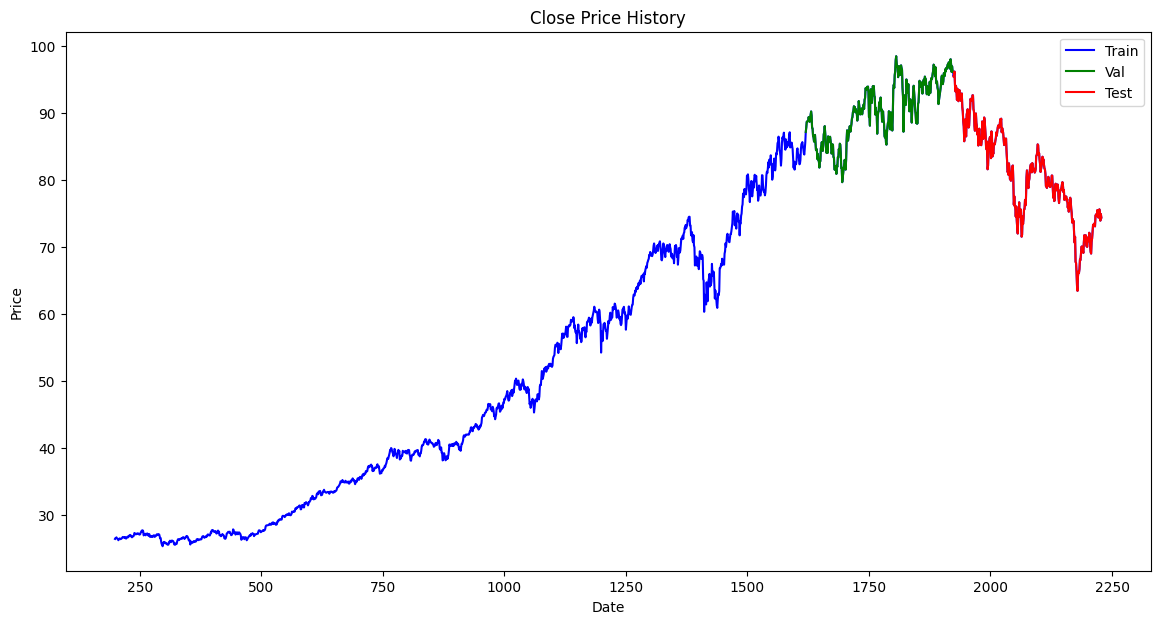

In [11]:
# plot line graph of price for entire df, price column is df['Close']
last_15_percent_index = int(len(df) * 0.85)
last_30_percent_index = int(len(df) * 0.70)

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Train', color='blue')
plt.plot(df['Close'].iloc[last_30_percent_index:last_15_percent_index], label='Val', color='green')
plt.plot(df['Close'].iloc[last_15_percent_index:], label='Test', color='red')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<ipython-input-12-6cc8e2f799c7>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


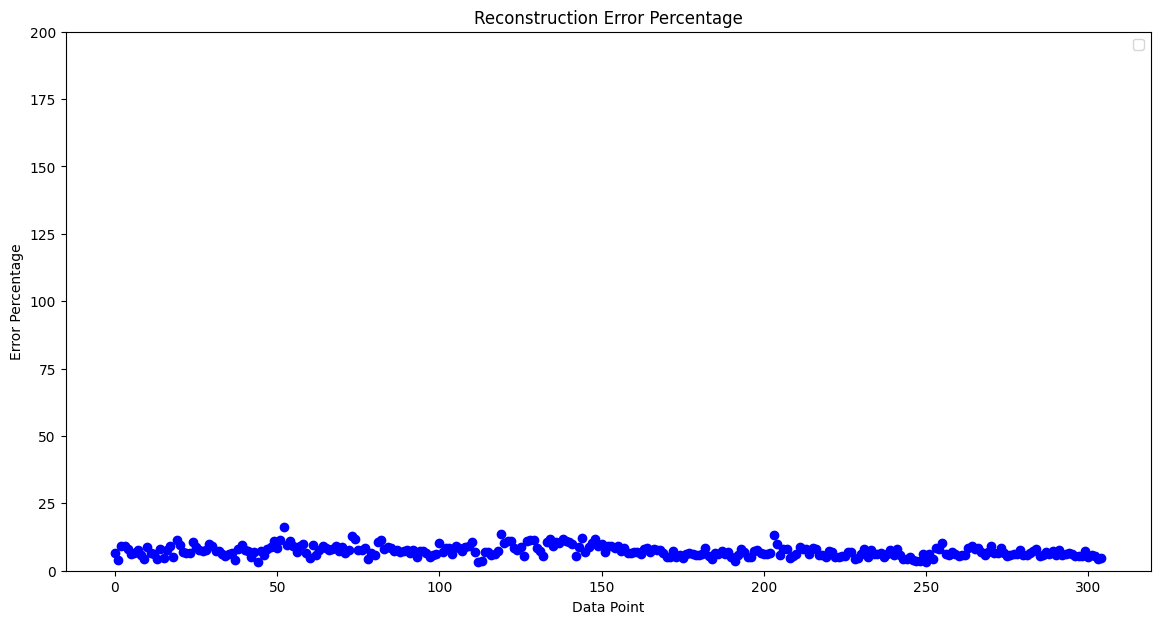

In [12]:
#   scatter graph to plot all errors, dont need to rearragne points
plt.figure(figsize=(14, 7))
plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, color='blue')
plt.ylim(0, 200)
plt.title('Reconstruction Error Percentage')
plt.xlabel('Data Point')
plt.ylabel('Error Percentage')
plt.legend()
plt.show()



In [13]:
# error count frequency per range
error_ranges = [0, 1, 2, 5, 10, 20, 50, 100, 200]
error_counts = np.zeros(len(error_ranges) - 1)
for i in range(len(error_ranges) - 1):
    error_counts[i] = np.sum((reconstruction_error_percentage > error_ranges[i]) & (reconstruction_error_percentage <= error_ranges[i + 1]))
print(error_counts)


[  0.   0.  29. 245.  31.   0.   0.   0.]


In [14]:
# print with descriptino
for i in range(len(error_ranges) - 1):
    print(f'Error percentage between {error_ranges[i]} and {error_ranges[i + 1]}: {error_counts[i]}')

Error percentage between 0 and 1: 0.0
Error percentage between 1 and 2: 0.0
Error percentage between 2 and 5: 29.0
Error percentage between 5 and 10: 245.0
Error percentage between 10 and 20: 31.0
Error percentage between 20 and 50: 0.0
Error percentage between 50 and 100: 0.0
Error percentage between 100 and 200: 0.0


In [15]:
#sum error count
np.sum(error_counts)

305.0

In [16]:
len(X_test)

305

In [17]:
# remove top 10 highest errors and get new error average without them
top_10_indices = np.argsort(reconstruction_error_percentage)[-10:]
top_10_indices

# remove from reconstruction_error_percentages
reconstruction_error_percentage_no_top_10 = np.delete(reconstruction_error_percentage, top_10_indices)

print(f'Original Error Percentage Mean: {reconstruction_error_percentage_mean}')
print(f'Error Percentage Mean Without Top 10: {np.mean(reconstruction_error_percentage_no_top_10)}')


Original Error Percentage Mean: 7.309392811670209
Error Percentage Mean Without Top 10: 7.126786029527858


In [18]:
# get cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities  = np.diag(cosine_similarity(X_test, reconstructed_test))

# get some statistics on the cosine similarities
cosine_similarities_mean = np.mean(cosine_similarities)
cosine_similarities_std = np.std(cosine_similarities)
cosine_similarities_min = np.min(cosine_similarities)
cosine_similarities_max = np.max(cosine_similarities)

print(f'Cosine Similarity Mean: {cosine_similarities_mean}')
print(f'Cosine Similarity Std: {cosine_similarities_std}')
print(f'Cosine Similarity Min: {cosine_similarities_min}')
print(f'Cosine Similarity Max: {cosine_similarities_max}')


Cosine Similarity Mean: 0.9959728031727316
Cosine Similarity Std: 0.003528525034509367
Cosine Similarity Min: 0.9583908621188414
Cosine Similarity Max: 0.9990955588992626


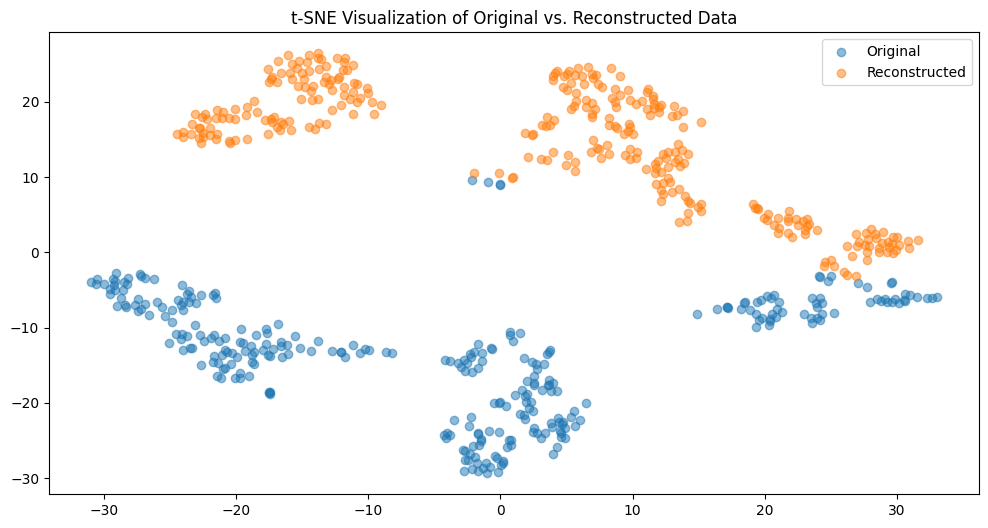

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine original and reconstructed vectors
X_combined = np.vstack([X_test, reconstructed_test])
labels = ["Original"] * len(X_test) + ["Reconstructed"] * len(reconstructed_test)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X_tsne[:len(X_test), 0], X_tsne[:len(X_test), 1], label="Original", alpha=0.5)
plt.scatter(X_tsne[len(X_test):, 0], X_tsne[len(X_test):, 1], label="Reconstructed", alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of Original vs. Reconstructed Data")
plt.show()


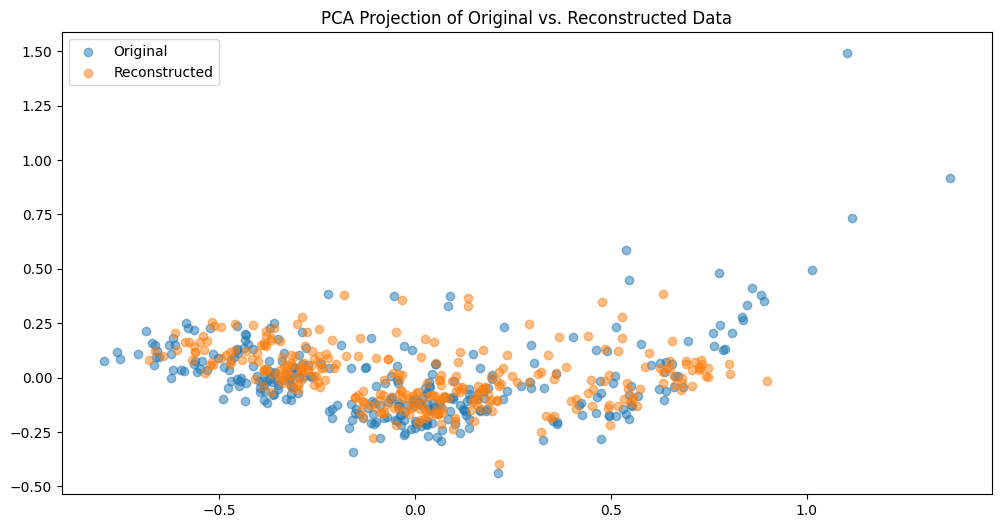

In [20]:
from sklearn.decomposition import PCA

X_combined = np.vstack([X_test, reconstructed_test])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:len(X_test), 0], X_pca[:len(X_test), 1], label="Original", alpha=0.5)
plt.scatter(X_pca[len(X_test):, 0], X_pca[len(X_test):, 1], label="Reconstructed", alpha=0.5)
plt.legend()
plt.title("PCA Projection of Original vs. Reconstructed Data")
plt.show()


In [21]:
for i in range (50,100):
    print(f'Index: {i}')
    calculate_index_error_percentage(i, X_test, reconstructed_test)

Index: 50
8.42667294671495
Index: 51
11.49410188797686
Index: 52
16.058710639919262
Index: 53
9.59267044285142
Index: 54
11.185562857347366
Index: 55
9.34756309815999
Index: 56
6.942670225159145
Index: 57
9.358047585803714
Index: 58
9.781616349697222
Index: 59
6.580098356568359
Index: 60
4.650597045960303
Index: 61
9.442226765408094
Index: 62
6.012598128697655
Index: 63
7.786077589080219
Index: 64
9.350489668906338
Index: 65
8.434830179604266
Index: 66
7.797417848667107
Index: 67
7.878519149450354
Index: 68
9.042622008662798
Index: 69
7.478807994096845
Index: 70
8.958295151753335
Index: 71
6.526247434789158
Index: 72
7.684663691985004
Index: 73
12.844989989795131
Index: 74
11.82166851841047
Index: 75
7.644490292929327
Index: 76
7.679389009977676
Index: 77
8.588470023317281
Index: 78
4.16827418474531
Index: 79
6.744395608107648
Index: 80
5.706029169062536
Index: 81
10.52101951932397
Index: 82
11.259741161565223
Index: 83
7.990371302624612
Index: 84
8.659030994932305
Index: 85
8.54056256

In [22]:
from numpy.linalg import norm

euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
print(f"Average Euclidean Distance: {euclidean_dist:.4f}")

relative_error = euclidean_dist / np.mean(np.linalg.norm(X_test, axis=1))
print(f"Relative Euclidean Error: {relative_error:.4f}")



Average Euclidean Distance: 0.2744
Relative Euclidean Error: 0.0874


In [ ]:
import itertools
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import os

# Hyperparameters to tune
learning_rates = [0.0001, 0.0005, 0.001, 0.01]
dropout_rates = [0.0, 0.1, 0.2, 0.3]
batch_sizes = [16, 32, 64]
patience_values = [20, 30, 40]

# Function to run a trial
def run_trial(learning_rate, dropout_rate, batch_size, patience):
    # Initialize model
    autoencoder = Autoencoder(input_dim, encoding_dim, dropout_rate).to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()  # Using MSE for standard loss

    # Train Autoencoder
    autoencoder.train()
    best_val_loss = float('inf')
    patience_counter = 0

    dataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                                          torch.tensor(X_train, dtype=torch.float32).to(device)),
                            batch_size=batch_size, shuffle=True, num_workers=0)

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, _ in dataloader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(batch_X)
            loss = criterion(outputs, batch_X)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)

        # Validation loss
        autoencoder.eval()
        with torch.no_grad():
            val_outputs = autoencoder(torch.tensor(X_val, dtype=torch.float32).to(device))
            val_loss = criterion(val_outputs, torch.tensor(X_val, dtype=torch.float32).to(device)).item()

            # Calculate Relative Euclidean Error
            relative_error = np.mean(np.abs(X_val - val_outputs.cpu().numpy()) / (np.abs(X_val) + 1e-8), axis=1) * 100
            relative_error_mean = np.mean(relative_error)

            # Combine all metrics (you can adjust the weights here)
            combined_metric = 0.8 * val_loss + 0.2* relative_error_mean  # Adjust the weights as needed

        # Early stopping
        if combined_metric < best_val_loss:
            best_val_loss = combined_metric
            patience_counter = 0
            torch.save(autoencoder.state_dict(), autoencoder_model_file)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Return the combined metric for this trial
    return best_val_loss


# Grid search over hyperparameter combinations
def hyperparameter_tuning():
    hyperparameter_combinations = list(itertools.product(learning_rates, dropout_rates, batch_sizes, patience_values))
    count = 1
    results = []
    for combination in hyperparameter_combinations:
        learning_rate, dropout_rate, batch_size, patience = combination
        print(f"Running trials for: LR={learning_rate}, Dropout={dropout_rate}, Batch size={batch_size}, Patience={patience}")
        print(f"Running {count} of 144")
        count += 1

        trial_losses = []
        for trial in range(5):
            print(f"  Trial {trial+1}")
            trial_loss = run_trial(learning_rate, dropout_rate, batch_size, patience)
            trial_losses.append(trial_loss)

        # Store the mean and std of the trial losses for this hyperparameter combination
        mean_loss = np.mean(trial_losses)
        std_loss = np.std(trial_losses)
        results.append({
            "learning_rate": learning_rate,
            "dropout_rate": dropout_rate,
            "batch_size": batch_size,
            "patience": patience,
            "mean_loss": mean_loss,
            "std_loss": std_loss
        })

    # Sort results by mean loss
    results.sort(key=lambda x: x["mean_loss"])

    # Print the best hyperparameters and results
    print("\nBest Hyperparameters:")
    best_result = results[0]
    print(f"Learning Rate: {best_result['learning_rate']}, Dropout Rate: {best_result['dropout_rate']}, "
          f"Batch Size: {best_result['batch_size']}, Patience: {best_result['patience']}, "
          f"Mean Loss: {best_result['mean_loss']:.4f}, Std Loss: {best_result['std_loss']:.4f}")

    return results

# Run hyperparameter tuning
results = hyperparameter_tuning()


Running trials for: LR=0.0001, Dropout=0.0, Batch size=16, Patience=20
Running 1 of 144
  Trial 1
  Trial 2
  Trial 3
  Trial 4
  Trial 5
Running trials for: LR=0.0001, Dropout=0.0, Batch size=16, Patience=30
Running 2 of 144
  Trial 1
  Trial 2
  Trial 3
  Trial 4
  Trial 5
Running trials for: LR=0.0001, Dropout=0.0, Batch size=16, Patience=40
Running 3 of 144
  Trial 1
  Trial 2
  Trial 3
  Trial 4
  Trial 5
Running trials for: LR=0.0001, Dropout=0.0, Batch size=32, Patience=20
Running 4 of 144
  Trial 1
  Trial 2
  Trial 3
  Trial 4
  Trial 5
Running trials for: LR=0.0001, Dropout=0.0, Batch size=32, Patience=30
Running 5 of 144
  Trial 1
  Trial 2
  Trial 3
  Trial 4
  Trial 5
Running trials for: LR=0.0001, Dropout=0.0, Batch size=32, Patience=40
Running 6 of 144
  Trial 1
  Trial 2
  Trial 3
  Trial 4
  Trial 5
Running trials for: LR=0.0001, Dropout=0.0, Batch size=64, Patience=20
Running 7 of 144
  Trial 1
  Trial 2
  Trial 3
  Trial 4
  Trial 5
Running trials for: LR=0.0001, Dro

In [25]:
for i in results:
    print(i)

{'learning_rate': 0.0005, 'dropout_rate': 0.3, 'batch_size': 16, 'patience': 40, 'mean_loss': 0.14377620751605127, 'std_loss': 0.019548464453295368}
{'learning_rate': 0.001, 'dropout_rate': 0.0, 'batch_size': 16, 'patience': 40, 'mean_loss': 0.14848780149882806, 'std_loss': 0.03027518117550535}
{'learning_rate': 0.0005, 'dropout_rate': 0.1, 'batch_size': 16, 'patience': 40, 'mean_loss': 0.15640574591078274, 'std_loss': 0.03405794724235919}
{'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32, 'patience': 40, 'mean_loss': 0.1633282818789097, 'std_loss': 0.042428064288146126}
{'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 32, 'patience': 40, 'mean_loss': 0.1644419013958066, 'std_loss': 0.023282405611364403}
{'learning_rate': 0.001, 'dropout_rate': 0.1, 'batch_size': 16, 'patience': 40, 'mean_loss': 0.16728987578820925, 'std_loss': 0.027786075559370085}
{'learning_rate': 0.0005, 'dropout_rate': 0.0, 'batch_size': 16, 'patience': 40, 'mean_loss': 0.16735036661947722,